# CNN for Classification
---
In this notebook, we define **and train** an CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [12]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [13]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

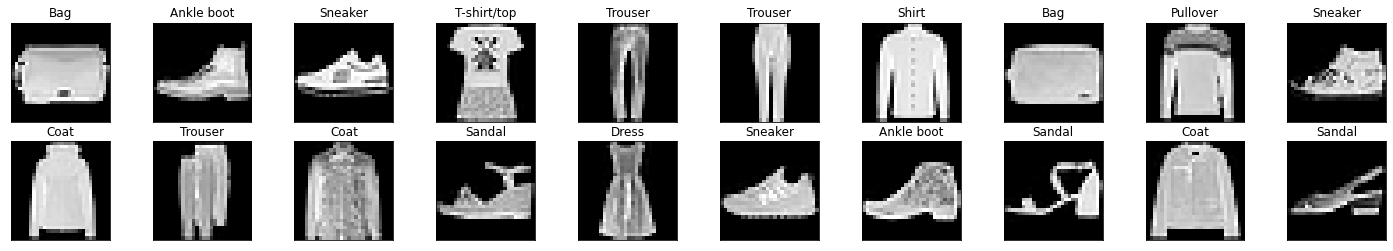

In [14]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

### TODO: Define the Net

Define the layers of your **best, saved model from the classification exercise** in the function `__init__` and define the feedforward behavior of that Net in the function `forward`. Defining the architecture here, will allow you to instantiate and load your best Net.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

        # In the constructor the
    # layers are defined
    def __init__(self):
        super(Net, self).__init__()

        # The first layer is a convolution layer with 1 input channel (since
        # the photos are in grayscale) and 10 output channels / feature maps (
        # by applying 10 image filters). The image filters are convolution
        # kernels with shape (3,3)
        #
        # The general formula for the output of the layers is
        # output_dim = (W-F)/S + 1 where `W` is the image's height || width,
        # `F` the filter size and `S` the stride.
        #
        # Using the formula above:
        # (28-3)/1 + 1 = 25/1 + 1 = 26
        # so it's output shape will be (batch_size, 10, 26, 26)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=3, stride=1)

        # The second layer is a MaxPooling layer. With a kernel of shape (2,2)
        # and a stride of 2. The MaxPooling layer will convolve with it's
        # input and for each grid it select's the maximum value -- this
        # basically allows the network to abstract features that are
        # present, no matter the orientation or size of an object.
        #
        # Using the formula above:
        # (26-2)/2 + 1 = 24/2 + 1 = 13
        # so it's output shape will be (batch_size, 10, 13, 13)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        # (13-3)/1 + 1 = 11
        # Hence the output of a single image will be in shape (32, 11, 11)
        self.conv2 = nn.Conv2d(10, 20, 3)

        # Before the fully connected layer another MaxPooling layer is
        # applied again.
        #
        # (11-2)/2 + 1 = 9/2 + 1 = 5.5 -- rounded down this is 5;
        # So the shape of a single image is (32, 5, 5)
        # A fully connected layer to all our classes (which there were 10 of)
        self.fc1 = nn.Linear(in_features=5 * 5 * 20, out_features=10)

    # Feed forward behaviour of the network
    def forward(self, x):
        # Feed it thru the convolutional layer
        x = self.conv1(x)

        # Apply a ReLU to it
        x = F.relu(x)

        # print('Shape after CONV1:', x.shape)

        # Feed it thru the MaxPooling layer
        # It's output will be in shape (batch_size, 10, 13, 13)
        x = self.maxpool1(x)

        # print('Shape after MAXPOOL1:', x.shape)

        x = self.conv2(x)

        x = F.relu(x)

        # print('Shape after CONV2:', x.shape)

        # We will use the same maxpool layer used after conv1
        x = self.maxpool1(x)

        # print('Shape after MAXPOOL2:', x.shape)

        # Flatten the output from the MaxPooling layer
        # so it can be fed into the fully connected layer.
        # This transforms (batch_size, 10, 13, 13) into
        # (batch_size, 13 * 13 * 10)
        x = x.view(x.size(0), -1)

        # print('Shape after RESHAPE:', x.shape)

        # Pass it thru the fully connected layer.
        x = self.fc1(x)

        # The last nodes will contain float values; we for these
        # to be probabilities so we use a softmax function that will
        # transform our floats to probabilities -- all added up being 1.
        #
        # Since our first dimension is our batch size we want the softmax
        # to be performed over the second dimension `1` which will be the
        # values themselves.
        x = F.log_softmax(x, dim=1)

        return x



### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters. This notebook needs to know the network architecture, as defined above, and once it knows what the "Net" class looks like, we can instantiate a model and load in an already trained network.

You should have a trained net in `saved_models/`.


In [16]:
# instantiate your Net
net = Net()

# load the net parameters by name, uncomment the line below to load your model
net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


## Feature Visualization

To see what your network has learned, make a plot of the learned image filter weights and the activation maps (for a given image) at each convolutional layer.

### TODO: Visualize the learned filter weights and activation maps of the convolutional layers in your trained Net

Choose a sample input image and apply the filters in every convolutional layer to that image to see the activation map.

First convolutional layer


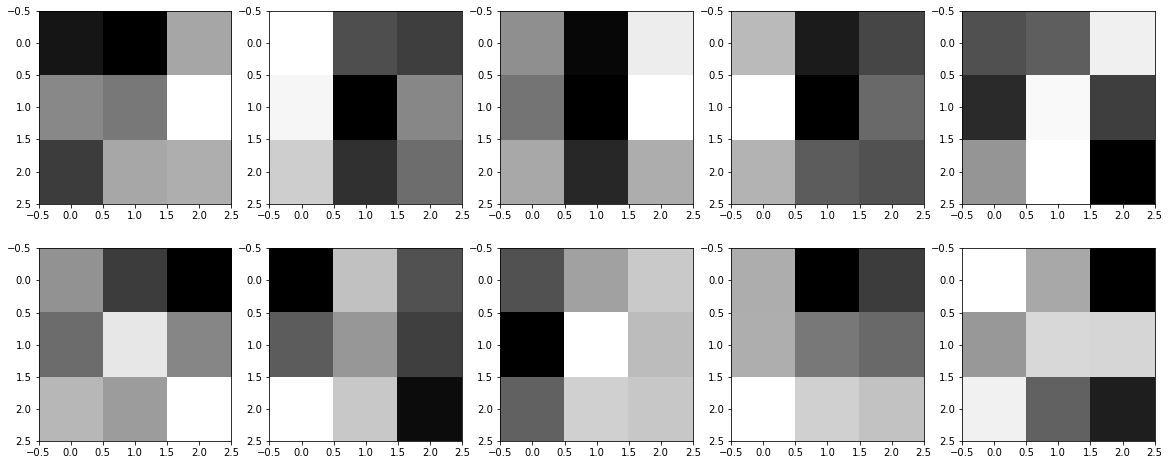

In [17]:
# As a reminder, here is how we got the weights in the first conv layer (conv1), before
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

### Question: Choose a filter from one of your trained convolutional layers; looking at these activations, what purpose do you think it plays? What kind of feature do you think it detects?
